In [1]:
import json
import requests as rq
import pandas as pd
import numpy as np
import time
import itertools
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
G=nx.Graph()
import pymongo
from pymongo import MongoClient
import community

In [217]:
list_summoners = pd.read_excel('LVPSummoner.xlsx',
                      sheetname = 'table_output',
                      header = 0,
                      index_col = 0,
                      parse_cols = "A",
                      convert_float = True)
len(list_summoners)

summ_file = pd.read_excel('LVP_Working_File_Simple.xlsx',
                      sheetname = 'Sheet1',
                      header = 0,
                      parse_cols = "A:E",
                      convert_float = True, index=False)

C:\ProgramData\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  del sys.path[0]


In [340]:
def most_important(H):
    """ returns a copy of G with
     the most important nodes
     according to the pagerank """ 
    ranking = nx.betweenness_centrality(H).items()
    r = [x[1] for x in ranking]
    m = sum(r)/len(r) # mean centrality
    t = m*3 # threshold, we keep only the nodes with 3 times the mean
    Gt = H.copy()
    for k, v in ranking:
        if v < t:
            Gt.remove_node(k)
    return Gt, m

def most_important_w(H):
    """ returns a copy of G with
     the most important nodes
     according to the pagerank """ 
    ranking = nx.betweenness_centrality(H, weight= 'matches_together').items()
    r = [x[1] for x in ranking]
    m = sum(r)/len(r) # mean centrality
    t = m*3 # threshold, we keep only the nodes with 3 times the mean
    Gt = H.copy()
    for k, v in ranking:
        if v < t:
            Gt.remove_node(k)
    return Gt, m

In [163]:
list_records = []
for i in range(len(list_summoners)):
    G = nx.read_graphml("networks/playerNetwork_"+ str(list_summoners.index[i]) +".graphml")
    
    # Características globales e id
    ego_id = G.graph['ego_id']
    num_nodes = len(list(G.nodes()))
    
    # Elimino el ego
    G.remove_node(G.graph['ego_id'])
    
    # Partition Louvain
    partition = community.best_partition(G)
    num_communities = len(set(partition.values()))
    modularity = community.modularity(partition, G)    
    
    # Measures
    num_components = nx.number_connected_components(G)
    density = nx.density(G)
    node_coverage = len(list(G.nodes()))/(G.graph['total_matches']*4)
    
    # Giant component
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
    G0 = Gcc[0]
    giant_component_coverage = len(list(G0.nodes()))/len(list(G.nodes()))
    
    # Avg Degree
    degrees = G.degree()
    sum_of_edges = 0
    for a, b in list(degrees):
        sum_of_edges = sum_of_edges + b
    avg_degree = sum_of_edges/len(list(G.nodes()))
    
    # Betweenness Centrality (most important nodes)
    Gt, m = most_important(G)
    num_important_nodes = len(list(Gt))
    perc_important_nodes = len(list(Gt))/len(list(G.nodes()))
    mean_centrality = m
    
    
    list_records.append((ego_id, num_nodes, num_communities, modularity, num_components, density, 
                         node_coverage, giant_component_coverage, avg_degree, perc_important_nodes, mean_centrality))
    
    

In [164]:
len(list_records)

439

In [165]:
labels = ['ego_id', 'num_nodes', 'num_communities', 'modularity', 'num_components', 'density', 
          'node_coverage', 'giant_component_coverage', 'avg_degree','perc_important_nodes', 'mean_centrality']
egonets_df = pd.DataFrame.from_records(list_records, columns=labels)

In [166]:
egonets_df.head()

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality
0,19459077,18,2,0.042192,1,0.389706,0.061594,1.000000,6.235294,0.058824,0.046569
1,20501992,22,3,0.538265,2,0.190476,0.750000,0.809524,3.809524,0.095238,0.036090
2,23407188,673,97,0.807652,85,0.005314,0.815534,0.491071,3.565476,0.007440,0.000517
3,27281117,45,13,0.185415,3,0.110994,0.297297,0.818182,4.772727,0.090909,0.015781
4,28306135,329,27,0.788217,25,0.011617,0.738739,0.634146,3.798780,0.015244,0.002134


In [ ]:
egonets_df.to_csv('egonets_df.csv', index=False)
#pd.read_csv('egonets_df.csv')

In [218]:
summ_file['Summ_ID'] = summ_file['Summ_ID'].astype(str)
egonets_data = egonets_df.merge(summ_file, how="inner", left_on="ego_id", right_on='Summ_ID')

In [219]:
egonets_data['result'] = pd.Categorical.from_array(egonets_data['Teamplay']).labels

C:\ProgramData\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  """Entry point for launching an IPython kernel.


In [230]:
egonets_data.shape
egonets_data.to_csv('egonets_data.csv', index=False)
egonets_data.head()

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result
0,19459077,18,2,0.042192,1,0.389706,0.061594,1.000000,6.235294,0.058824,0.046569,19459077,BRONZE,Bot - ADC,Equipo completo premade,69,0
1,20501992,22,3,0.538265,2,0.190476,0.750000,0.809524,3.809524,0.095238,0.036090,20501992,BRONZE,Bot - ADC,Premade de dos personas,7,1
2,23407188,673,97,0.807652,85,0.005314,0.815534,0.491071,3.565476,0.007440,0.000517,23407188,BRONZE,Support,Premade de dos personas,206,1
3,27281117,45,13,0.185415,3,0.110994,0.297297,0.818182,4.772727,0.090909,0.015781,27281117,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,37,2
4,28306135,329,27,0.788217,25,0.011617,0.738739,0.634146,3.798780,0.015244,0.002134,28306135,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de dos personas,111,1


In [231]:
# Normalizo communities y components
egonets_data['num_communities'] = egonets_data['num_communities']/egonets_data['Summ_totalGames']
egonets_data['num_components'] = egonets_data['num_components']/egonets_data['Summ_totalGames']

In [236]:
egonets_data['num_communities'].corr(egonets_data['num_components'])

0.86290080008415682

In [268]:
variable_names = ['Modularity', 'Components', 'Density', 'Coverage', 'Giant_Component_Coverage', 
                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']
target_names = ['Premade', 'Duo', 'Grupo', 'Solo']
X = egonets_data.values[:, 3:11]
Y = egonets_data['result'].values

In [269]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)

clf = tree.DecisionTreeClassifier(criterion = "gini", max_features=None, max_depth=4, min_samples_leaf=2)
clf = clf.fit(X_train, y_train)

In [270]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=variable_names, class_names=target_names,  
                         filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)  
graph.render("egonets")

'egonets.pdf'

In [271]:
y_pred = clf.predict(X_test)
y_pred

array([1, 1, 1, 3, 3, 2, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 2, 1, 3, 1, 0, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 3, 1, 0, 1, 1, 2,
       1, 3, 2, 3, 1, 1, 3, 1, 2, 3, 2, 1, 1, 1, 1, 0, 1, 2, 1, 3, 1, 2, 1,
       1, 1, 1, 1, 1, 3, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 3], dtype=int8)

In [272]:
print("Accuracy is " + str(accuracy_score(y_test,y_pred)*100))

Accuracy is 52.2727272727


# K-Means

In [242]:
from sklearn import cluster

In [273]:
X = egonets_data.values[:, 3:11]
Y = egonets_data['result'].values


k_means = cluster.KMeans(n_clusters=4)
k_means.fit(X) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [274]:
print(k_means.labels_[::3])

print(Y[::3])

[2 2 0 0 3 2 0 2 3 0 3 0 0 1 3 0 1 3 3 1 1 3 1 2 0 1 3 3 1 1 3 0 0 1 1 0 3
 1 3 1 1 0 0 3 0 0 0 3 0 3 1 0 1 2 2 1 0 3 0 0 3 0 0 2 1 2 0 1 1 0 0 3 3 0
 0 3 3 3 3 3 0 3 1 3 3 3 3 3 1 3 3 3 1 0 1 0 0 2 0 3 0 1 1 2 0 1 1 0 0 3 1
 3 0 2 3 3 3 0 0 2 0 2 3 3 2 3 3 3 0 1 0 0 2 0 0 3 3 2 0 3 1 3 1 0 3 3 2]
[0 2 2 1 3 2 2 0 1 1 2 1 2 3 1 2 3 0 3 1 3 0 3 0 1 3 2 3 3 3 0 2 1 1 2 1 2
 1 2 3 1 2 1 1 3 1 0 2 1 2 3 2 3 1 2 3 1 1 1 2 1 2 2 2 3 2 2 2 3 1 2 1 1 1
 2 1 3 2 1 1 3 0 3 1 1 1 1 3 2 0 0 1 2 1 3 2 1 2 2 2 2 1 0 2 0 3 2 0 2 2 1
 2 1 1 2 0 1 1 2 2 2 1 2 1 1 1 1 2 0 3 1 2 2 1 2 2 1 1 3 1 1 1 3 2 1 1 2]


# A PARTIR DE AQUÍ

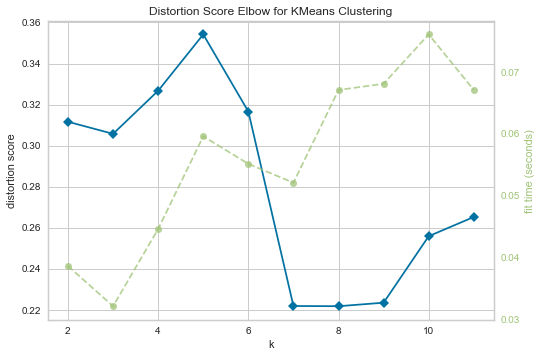

In [275]:
import yellowbrick
from sklearn.cluster import MiniBatchKMeans, KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,12))

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

## Hay un cambio de ángulo claro en el k=7

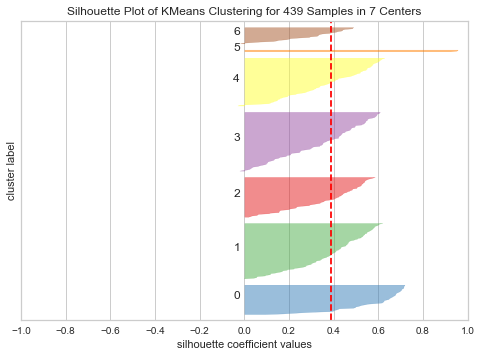

In [276]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

## Voy a reducir el número de parámetros (en realidad sólo trasteo porque aquí el y_train es el supervisado)

In [277]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=4).fit(X_train, y_train)
X_train_new = selector.fit_transform(X_train, y_train)
X_train_new.shape

(307, 4)

In [278]:
pd.DataFrame.from_records(X_train_new).head()

,0,1,2,3
0,0.303571,0.714286,0.568750,3.762500
1,0.610169,0.846133,0.144288,3.341158
2,0.142857,0.590659,0.745736,4.117829
3,0.614849,0.850348,0.261937,3.326057
4,0.730000,0.905000,0.157459,3.220994


In [279]:
pd.DataFrame.from_records(X_train).head()

,0,1,2,3,4,5,6,7
0,0.678970,0.303571,0.023664,0.714286,0.568750,3.762500,0.018750,0.002203
1,0.970618,0.610169,0.000523,0.846133,0.144288,3.341158,0.006260,0.000005
2,0.673775,0.142857,0.006394,0.590659,0.745736,4.117829,0.021705,0.001468
3,0.866468,0.614849,0.002270,0.850348,0.261937,3.326057,0.002729,0.000051
4,0.942200,0.730000,0.008922,0.905000,0.157459,3.220994,0.008287,0.000066


## Está cogiendo num_components, Coverage, Giant_Component_Coverage,          AVG_degree. Modularity no queda muy lejos, al igual debería coger 5 parámetros.

In [280]:
print(selector.scores_)

[ 1.71430484  8.56140325  0.33093962  2.25028574  7.42942232  2.5215404
  0.48175671  0.09012724]


In [281]:
# Lo hago
selector = SelectKBest(chi2, k=5).fit(X_train, y_train)
X_train_new = selector.fit_transform(X_train, y_train)
print(X_train_new.shape)
print(selector.scores_)

(307, 5)
[ 1.71430484  8.56140325  0.33093962  2.25028574  7.42942232  2.5215404
  0.48175671  0.09012724]


In [311]:
X_reduced = egonets_data.values[:, [3,4,6,7,8]]

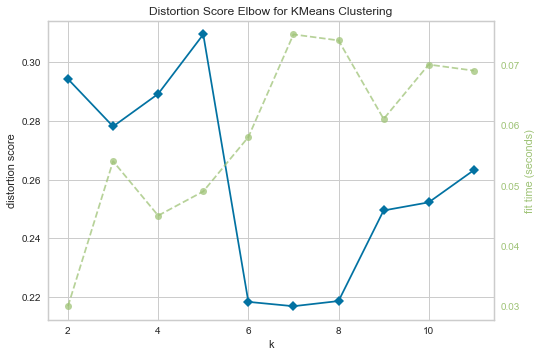

In [283]:
visualizer = KElbowVisualizer(KMeans(), k=(2,12))

visualizer.fit(X_reduced) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

## Reduciendo, salen entre 6 y 8. 6 mejor, que son menos.

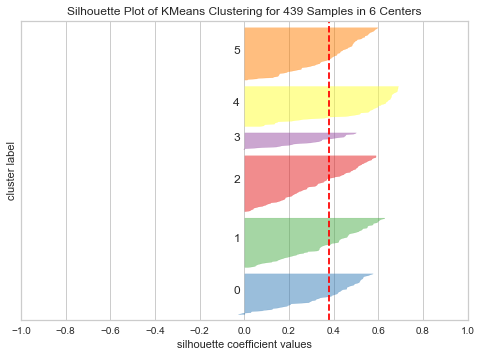

In [288]:
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_reduced) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

¿Por qué a veces al correr el modelo sale algún grupo vacío? ¿Bad inicialization, que dicen por ahí?

# VAMOS A HACERLO BIEN

In [289]:
# AHORA LO HAGO BIEN, tras ver que parecen 7 clusters lo óptimo

k_means = cluster.KMeans(n_clusters=7)
k_means.fit(X)
print(k_means.labels_[::3])

[5 2 4 0 0 2 0 4 3 0 3 0 0 1 3 4 1 0 0 1 1 0 1 4 0 1 0 3 1 1 3 4 0 3 1 0 0
 1 0 1 1 0 4 3 0 4 4 3 0 3 1 0 3 4 2 1 4 0 4 0 0 4 0 2 3 4 4 3 1 0 4 3 3 0
 0 3 3 3 3 0 0 3 1 3 3 3 3 3 1 0 0 3 1 0 3 0 0 2 4 3 0 1 1 4 4 1 1 0 0 3 1
 3 0 2 0 3 3 0 0 2 4 4 3 3 4 3 3 3 4 1 0 4 2 4 4 3 3 2 0 3 1 0 6 0 3 3 2]


In [307]:
selector = SelectKBest(chi2, k=7).fit(X, k_means.labels_)
X_new = selector.fit_transform(X, k_means.labels_)
X_new.shape

(439, 7)

In [308]:
print(selector.scores_)

[  14.11974891   61.49585232   17.39589833   11.93051715   62.95942995
   21.62988664  154.56423431    2.51997038]


In [309]:
print(pd.DataFrame.from_records(X_new).head())
print(pd.DataFrame.from_records(X).head())

          0         1         2         3         4         5         6
0  0.042192  0.014493  0.389706  0.061594  1.000000  6.235294  0.058824
1  0.538265  0.285714  0.190476  0.750000  0.809524  3.809524  0.095238
2  0.807652  0.412621  0.005314  0.815534  0.491071  3.565476  0.007440
3  0.185415  0.081081  0.110994  0.297297  0.818182  4.772727  0.090909
4  0.788217  0.225225  0.011617  0.738739  0.634146  3.798780  0.015244
          0         1         2         3         4         5         6  \
0  0.042192  0.014493  0.389706  0.061594  1.000000  6.235294  0.058824   
1  0.538265  0.285714  0.190476  0.750000  0.809524  3.809524  0.095238   
2  0.807652  0.412621  0.005314  0.815534  0.491071  3.565476  0.007440   
3  0.185415  0.081081  0.110994  0.297297  0.818182  4.772727  0.090909   
4  0.788217  0.225225  0.011617  0.738739  0.634146  3.798780  0.015244   

          7  
0  0.046569  
1  0.036090  
2  0.000517  
3  0.015781  
4  0.002134  


Está cogiendo 1,2,4,5,6 -> 'Modularity', **'Components'**, **'Density'**, 'Coverage', **'Giant_Component_Coverage'**, 
                  **'AVG_degree'**,**'Perc_Important_Nodes'**, 'AVG_centrality' 

In [313]:
X_new_reduced = egonets_data.values[:, 3:10]

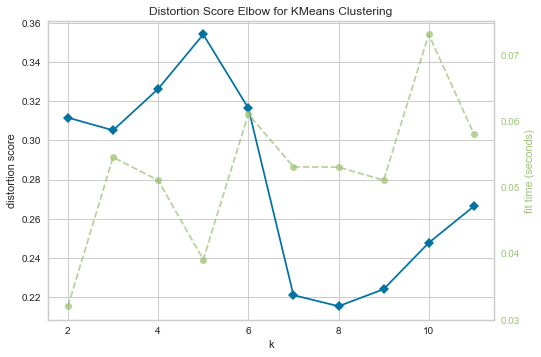

In [339]:
visualizer = KElbowVisualizer(KMeans(), k=(2,12))

visualizer.fit(X_new_reduced) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

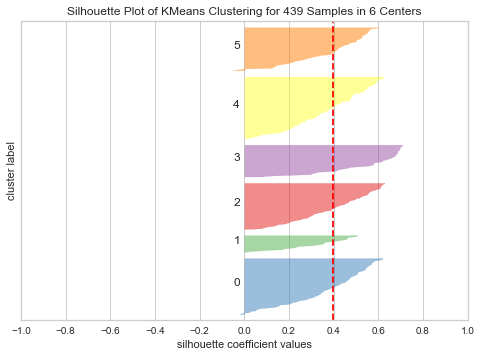

In [336]:
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_reduced) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

# EXTRA DATOS (WEIGHTED)

In [343]:
list_records_w = []
for i in range(len(list_summoners)):
    G = nx.read_graphml("networks/playerNetwork_"+ str(list_summoners.index[i]) +".graphml")
    
    # Características globales e id
    ego_id = G.graph['ego_id']
    
    # Elimino el ego
    G.remove_node(G.graph['ego_id'])
    
    # Partition Louvain (YA TENIA EN CUENTA EL PESO)
       
    # Measures (OK)
    
    # Giant component (OK)
    
    # Avg Degree (Añado peso)
    degrees = G.degree(weight= 'matches_together')
    sum_of_edges = 0
    for a, b in list(degrees):
        sum_of_edges = sum_of_edges + b
    avg_degree_w = sum_of_edges/len(list(G.nodes()))
    
    # Betweenness Centrality (most important nodes)
    Gt, m = most_important_w(G)
    num_important_nodes_w = len(list(Gt))
    perc_important_nodes_w = len(list(Gt))/len(list(G.nodes()))
    mean_centrality_w = m
    
    
    list_records_w.append((ego_id, avg_degree_w, perc_important_nodes_w, mean_centrality_w))

In [344]:
labels = ['ego_id', 'avg_degree_w','perc_important_nodes_w', 'mean_centrality_w']
egonets_df_w = pd.DataFrame.from_records(list_records_w, columns=labels)
egonets_df_w.to_csv('egonets_df_w.csv', index=False)